# multi-layer predictive coding

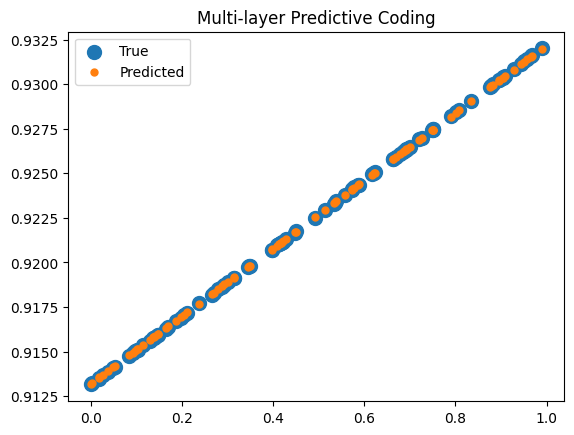

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray

# Activation functions
def relu(x: NDArray[np.float64]) -> NDArray[np.float64]:
    return np.maximum(0, x)

def relu_deriv(x: NDArray[np.float64]) -> NDArray[np.float64]:
    return (x > 0).astype(float)

# Predictive coding layer
class PCLayer:
    def __init__(self, input_dim: int, output_dim: int):
        self.w = np.random.randn(output_dim, input_dim) * 0.1
        self.b = np.zeros((output_dim, 1))
        self.u = np.zeros((output_dim, 1))  # state (neuron activities)
        self.e = np.zeros((output_dim, 1))  # prediction error

    def predict(self, input_u: NDArray[np.float64]) -> NDArray[np.float64]:
        return relu(self.w @ input_u + self.b)

    def update_error(self, input_u: NDArray[np.float64]):
        pred = self.predict(input_u)
        self.e = self.u - pred

    def update_state(self, input_u: NDArray[np.float64], lr_u: float):
        pred = self.predict(input_u)
        self.u -= lr_u * (self.u - pred)

    def update_weights(self, input_u: NDArray[np.float64], lr_w: float):
        grad = self.e * relu_deriv(self.w @ input_u + self.b)
        self.w += lr_w * (grad @ input_u.T)
        self.b += lr_w * grad

# Predictive coding network
class PCNetwork:
    def __init__(self, layer_sizes: list[int]):
        self.layers = [
            PCLayer(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes) - 1)
        ]

    def forward_pass(self, x: NDArray[np.float64], iterations: int = 10, lr_u: float = 0.1):
        # Set input
        self.layers[0].u = self.layers[0].predict(x)
        for _ in range(iterations):
            for i, layer in enumerate(self.layers[1:], start=1):
                prev_u = self.layers[i-1].u
                layer.update_error(prev_u)
                layer.update_state(prev_u, lr_u)

    def update_weights(self, x: NDArray[np.float64], lr_w: float = 0.01):
        for i, layer in enumerate(self.layers):
            input_u = x if i == 0 else self.layers[i-1].u
            layer.update_weights(input_u, lr_w)

    def predict(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        out = x
        for layer in self.layers:
            out = relu(layer.w @ out + layer.b)
        return out

# Create data
np.random.seed(1)
x = np.random.rand(1, 100)  # input (1D)
y = 3 * x + 1  # linear target

# Create network
net = PCNetwork([1, 10, 1])

# Train
for epoch in range(10):
    for i in range(x.shape[1]):
        x_i = x[:, i:i+1]
        y_i = y[:, i:i+1]
        net.layers[-1].u = y_i  # clamp output
        net.forward_pass(x_i)
        net.update_weights(x_i)

# Predict
y_pred = np.hstack([net.predict(x[:, i:i+1]) for i in range(x.shape[1])])

# Plot
plt.scatter(x.flatten(), y.flatten(), label='True', s=100)
plt.scatter(x.flatten(), y_pred.flatten(), label='Predicted', s=25)
plt.legend()
plt.title('Multi-layer Predictive Coding')
plt.show()


---

# References
- [ChatGPT conversation](https://chatgpt.com/share/6822a383-56b8-8010-b009-f868ee6e9144)